AQUI SE CONCATENAN LOS DISPOSITIVOS QUE SE ENCUENTRAN EN LA CARPETA DE DISPOSITIVOS

ENTRENAMIENTOS, SE GENERA NUEVO ARCHIVO CON EL NOMBRE  'Dispositivos_entrenamiento'

In [1]:
import pandas as pd

# CARGA DE DATOS CSV DE ENTRENAMIENTO
refrigerador =  'refrigerador'
ventilador = 'ventilador'

refrigerador_df = pd.read_csv(f"Dispositivos_Entrenamiento/{refrigerador}_Entrenamiento.csv")
ventilador_df = pd.read_csv(f"Dispositivos_Entrenamiento/{ventilador}_Entrenamiento.csv")


# AGREGAR COLUMNA DE ETIQUETA POR CADA DISPOSITIVO
refrigerador_df['dispositivo'] = 'refrigerador'
ventilador_df['dispositivo'] = 'ventilador'


# COMBINAR DATO EN UN SOLO DATAFRAME
datos_combinados = pd.concat([refrigerador_df, ventilador_df])

# GUARDAR ARCHIVO
datos_combinados.to_csv('Dispositivos_entrenamiento.csv', index=False)

print(datos_combinados.head())

                fecha  Corriente_linea1   dispositivo
0  2024-09-25_15-47-0          0.060845  refrigerador
1  2024-09-25_15-47-1          0.059059  refrigerador
2  2024-09-25_15-47-2          0.059609  refrigerador
3  2024-09-25_15-47-3          0.059245  refrigerador
4  2024-09-25_15-47-3          0.058898  refrigerador


AQUI OBSERVAMOS SUS COMPORTAMIENTOS DE AMBOS DISPOSITIVOS

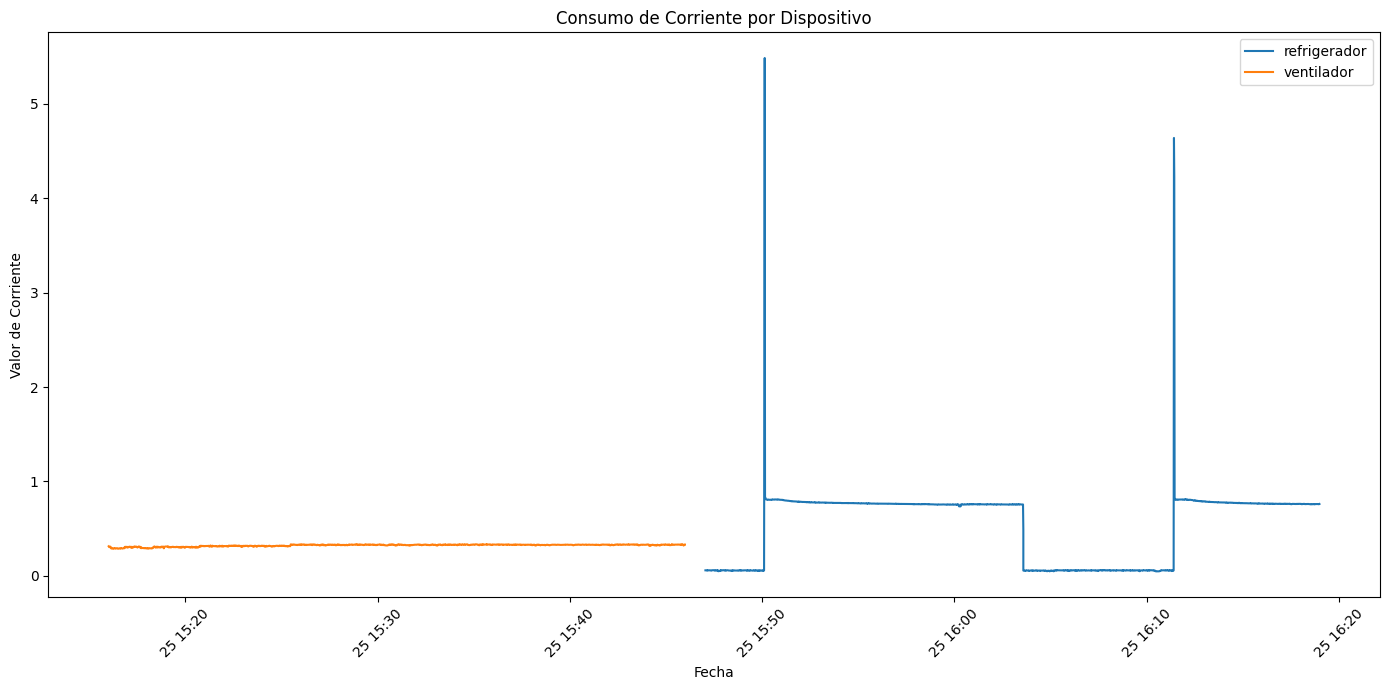

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

# Asegurarse de que la columna 'fecha' esté en el formato adecuado
datos_combinados['fecha'] = pd.to_datetime(datos_combinados['fecha'], format='%Y-%m-%d_%H-%M-%S', errors='coerce')

# Filtrar fechas inválidas que no pudieron ser convertidas
datos_combinados = datos_combinados.dropna(subset=['fecha'])

# Crear la gráfica de líneas para cada dispositivo
plt.figure(figsize=(14, 7))

# Graficar cada dispositivo
for dispositivo in datos_combinados['dispositivo'].unique():
    subset = datos_combinados[datos_combinados['dispositivo'] == dispositivo]
    plt.plot(subset['fecha'], subset['Corriente_linea1'], label=dispositivo)

# Configurar etiquetas y título
plt.xlabel('Fecha')
plt.ylabel('Valor de Corriente')
plt.title('Consumo de Corriente por Dispositivo')
plt.legend()

# Rotar las etiquetas del eje X para que se vean mejor
plt.xticks(rotation=45)

# Ajustar el diseño para que todo encaje
plt.tight_layout()

# Mostrar la gráfica
plt.show()


COMENZAMOS CON EL ENTRENAMIENTO

Para este punto iniciaremos extrayendo características de cada datos considerando:
media, desviación, corriente_max, corriente_min

In [3]:
#EXTRACCION DE CARACTERISTICAS DE CADA DISPOSITIVO, MEDIA, DESVIACION Y PICOS

# Calcular características estadísticas de corriente
def extraer_caracteristicas(df):
    df['media_corriente'] = df['Corriente_linea1'].rolling(window=5).mean()  # Media en una ventana de 5 muestras
    df['desviacion_corriente'] = df['Corriente_linea1'].rolling(window=5).std()  # Desviación estándar
    df['corriente_max'] = df['Corriente_linea1'].rolling(window=5).max()  # Corriente máxima
    df['corriente_min'] = df['Corriente_linea1'].rolling(window=5).min()  # Corriente mínima
    df = df.dropna()  # Elimina valores NaN generados por la ventana de tiempo
    return df

# Aplicar la extracción de características
datos_combinados = extraer_caracteristicas(datos_combinados) #SON LOS DATOS CONCATENAMOS DE AMBOS DISPOSITIVOS

# Selección de características y etiquetas
X = datos_combinados[['media_corriente', 'desviacion_corriente', 'corriente_max', 'corriente_min']]
y = datos_combinados['dispositivo']

Aqui dividimos los datos en donde el 80% será solo para entrenamiento con el Random Forest
y el otro 20% de prueba es decir que será una muestra para evaluar el rendimiento del modelo y verificar su capacidad de generalización en datos no vistos

In [4]:
#DIVISION DE DATOS

from sklearn.model_selection import train_test_split

# Dividir los datos en entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

EN ESTE PUNTO INICIA COMO EL ENTRENAMIENTO, AQUI GENERA LOS DATOS DE PREDICCION EN UN NUEVO CSV
Y DESPUÉS LOS INTERPRETARA EN NUESTROS DATOS GENERALES

Los datos generales son las mediciones generales de los dispositivos los cuales se encuenntran en la Carpeta Datos_generales


In [5]:
#ENTRENAMIENTO DEL MODELO RANDOM FOREST

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix


variable = 'Corriente_linea1'
# Crear el modelo de Random Forest
modelo_rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Entrenar el modelo
modelo_rf.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred = modelo_rf.predict(X_test)

# Evaluar el modelo
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


#PREDICCION CON NUEVOS DATOS

# Cargar nuevos datos
datos_generales = pd.read_csv(f"Datos_generales_{variable}.csv")

# Extraer características
datos_generales = extraer_caracteristicas(datos_generales)

# Predecir el dispositivo de cada registro
X_nuevos = datos_generales[['media_corriente', 'desviacion_corriente', 'corriente_max', 'corriente_min']]
predicciones = modelo_rf.predict(X_nuevos)

# Agregar las predicciones al DataFrame
datos_generales['dispositivo_predicho'] = predicciones

# Guardar los resultados en un archivo CSV
datos_generales.to_csv('Predicciones.csv', index=False)#VISUALIZACION


[[495   0]
 [  0 419]]
              precision    recall  f1-score   support

refrigerador       1.00      1.00      1.00       495
  ventilador       1.00      1.00      1.00       419

    accuracy                           1.00       914
   macro avg       1.00      1.00      1.00       914
weighted avg       1.00      1.00      1.00       914



VISUALIZACIÓN DE CORRIENTE REAL

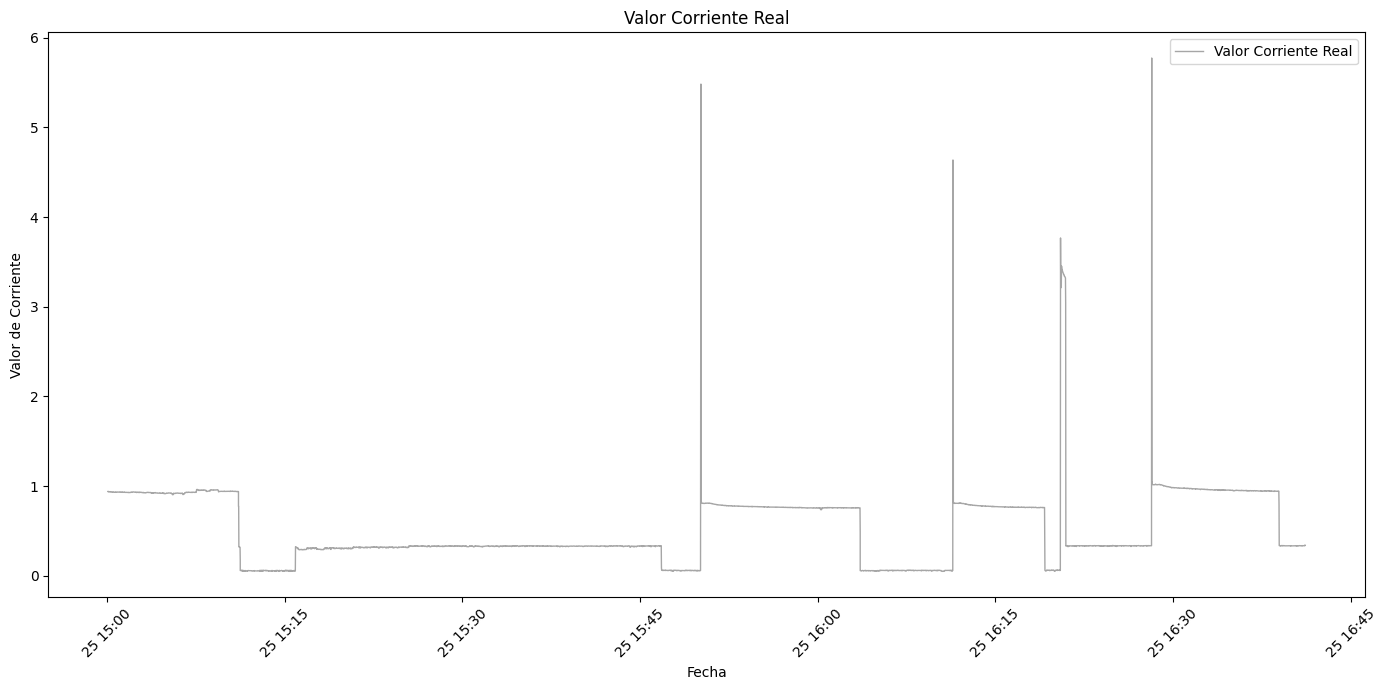

In [22]:
import matplotlib.pyplot as plt
import pandas as pd

# Asegurarse de que el índice de 'datos_generales' esté en formato de fecha y hora
# Si el índice no está en formato de fecha, convertirlo
if not isinstance(datos_generales.index, pd.DatetimeIndex):
    datos_generales['fecha'] = pd.to_datetime(datos_generales.index, format='%Y-%m-%d_%H-%M-%S', errors='coerce')

# Filtrar filas con fechas inválidas (en caso de que alguna conversión haya fallado)
datos_generales = datos_generales.dropna(subset=['Corriente_linea1'])

# Crear la gráfica de líneas
plt.figure(figsize=(14, 7))

# Graficar las corrientes reales (sin etiqueta de dispositivo)
plt.plot(datos_generales['fecha'], datos_generales['Corriente_linea1'], label='Valor Corriente Real', color='gray', alpha=0.7, linewidth=1)

# Configurar etiquetas y título
plt.xlabel('Fecha')
plt.ylabel('Valor de Corriente')
plt.title('Valor Corriente Real')
plt.xticks(rotation=45)

# Añadir leyenda
plt.legend()

# Ajustar el diseño para que todo encaje
plt.tight_layout()

# Mostrar la gráfica
plt.show()


PRIMERA VISUALIZACIÓN DE LAS PREDICCIONES CON VALORES REALES

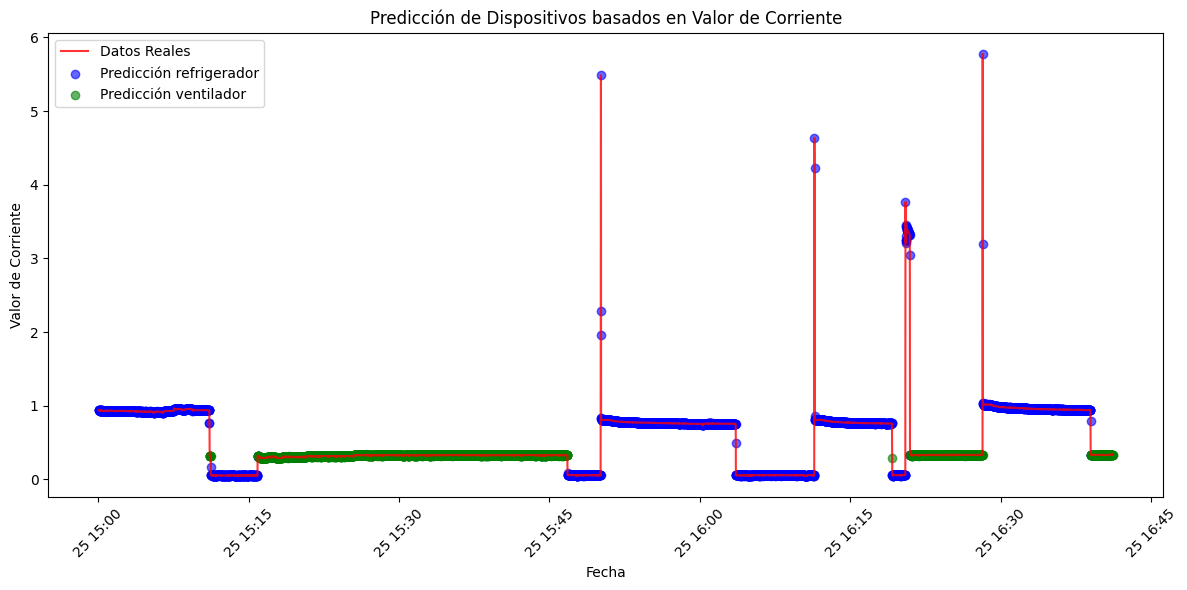

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# Asegurarse de que el índice de 'datos_generales' esté en formato de fecha y hora
if not isinstance(datos_generales.index, pd.DatetimeIndex):
    datos_generales['fecha'] = pd.to_datetime(datos_generales['fecha'], format='%Y-%m-%d_%H-%M-%S', errors='coerce')

# Filtrar filas con fechas inválidas
datos_generales = datos_generales.dropna(subset=['Corriente_linea1'])

# Configurar colores para cada dispositivo
colores = {'refrigerador': 'blue', 'ventilador': 'green'}

# Crear la gráfica de dispersión
plt.figure(figsize=(12, 6))

# Graficar los datos reales como una línea continua
plt.plot(datos_generales['fecha'], datos_generales['Corriente_linea1'], label='Datos Reales', color='red', alpha=0.8)

# Graficar la predicción de dispositivos como puntos
for dispositivo in datos_generales['dispositivo_predicho'].unique():
    subset = datos_generales[datos_generales['dispositivo_predicho'] == dispositivo]
    plt.scatter(subset['fecha'], subset['Corriente_linea1'], label=f'Predicción {dispositivo}', color=colores[dispositivo], alpha=0.6)

# Configurar etiquetas y título
plt.xlabel('Fecha')
plt.ylabel('Valor de Corriente')
plt.title('Predicción de Dispositivos basados en Valor de Corriente')
plt.xticks(rotation=45)
plt.legend()

# Ajustar y mostrar la gráfica
plt.tight_layout()
plt.show()


SEGUNDA VISUALIZACIÓN PREDICCIONES VS DATOS REALES

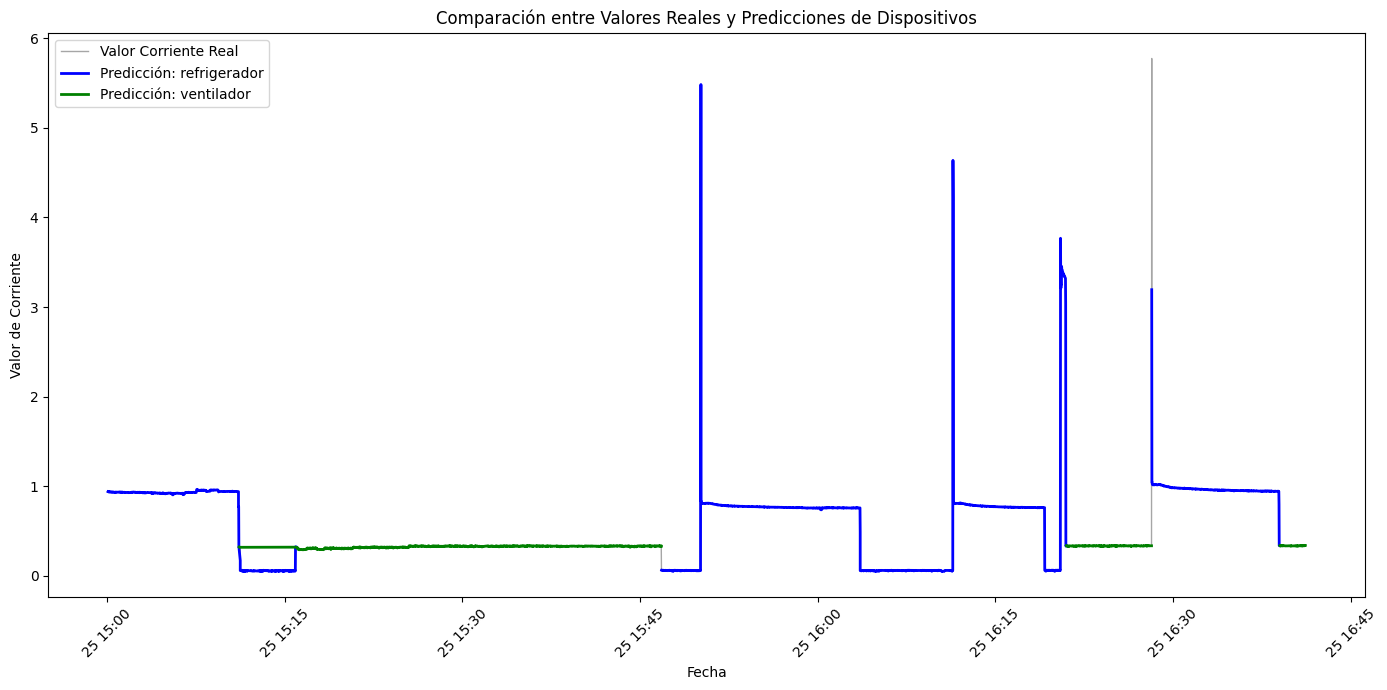

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Configurar colores más fuertes para cada dispositivo
colores_prediccion = {'refrigerador': 'blue', 'ventilador': 'green'}

# Asegurarse de que la columna 'fecha' esté en el formato adecuado
# Especificar el formato de la fecha, por ejemplo: '2024-09-25_15-00-04'
datos_generales['fecha'] = pd.to_datetime(datos_generales['fecha'], format='%Y-%m-%d_%H-%M-%S', errors='coerce')

# Filtrar fechas inválidas que no pudieron ser convertidas
datos_generales = datos_generales.dropna(subset=['fecha'])

# Crear la gráfica de líneas
plt.figure(figsize=(14, 7))

# Graficar las corrientes reales (sin etiqueta de dispositivo)
plt.plot(datos_generales['fecha'], datos_generales['Corriente_linea1'], label='Valor Corriente Real', color='gray', alpha=0.7, linewidth=1)

# Graficar las predicciones con colores más fuertes y líneas continuas solo donde existan datos
for dispositivo in datos_generales['dispositivo_predicho'].unique():
    # Filtrar los datos por dispositivo
    subset = datos_generales[datos_generales['dispositivo_predicho'] == dispositivo].copy()
    
    # Asegurarse de que la columna 'fecha' es un DatetimeIndex (no es necesario ya que lo hicimos antes)
    
    # Identificar las discontinuidades en el tiempo
    discontinuidades = subset['fecha'].diff() > pd.Timedelta('5min')  # Puedes ajustar el '5min' al valor que consideres
    
    # Introducir NaN donde hay discontinuidades para romper la línea
    subset.loc[discontinuidades, 'Corriente_linea1'] = np.nan
    
    # Graficar los datos filtrados
    plt.plot(subset['fecha'], subset['Corriente_linea1'], label=f'Predicción: {dispositivo}', color=colores_prediccion[dispositivo], linewidth=2)

# Configurar etiquetas y título
plt.xlabel('Fecha')
plt.ylabel('Valor de Corriente')
plt.title('Comparación entre Valores Reales y Predicciones de Dispositivos')
plt.xticks(rotation=45)
plt.legend()

# Ajustar el diseño para que todo encaje
plt.tight_layout()

# Mostrar la gráfica
plt.show()


VISUALIZACIÓN POR COMPORTAMIENTO DE CADA DISPOSITIVO

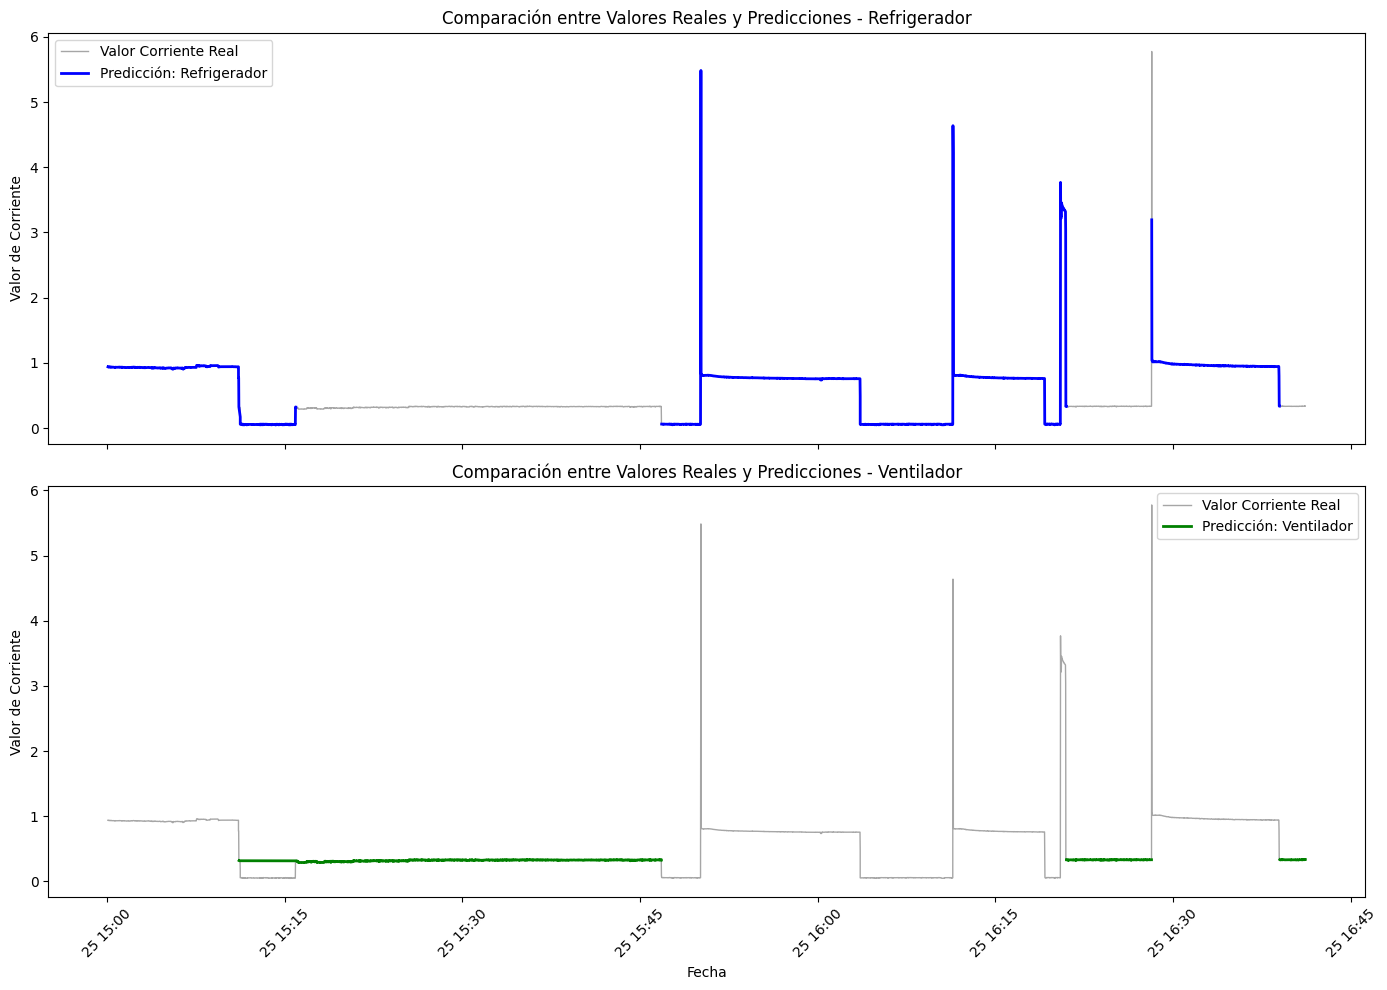

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Configurar colores más fuertes para cada dispositivo
colores_prediccion = {'refrigerador': 'blue', 'ventilador': 'green'}

# Asegurarse de que la columna 'fecha' esté en el formato adecuado
datos_generales['fecha'] = pd.to_datetime(datos_generales['fecha'], format='%Y-%m-%d_%H-%M-%S', errors='coerce')

# Filtrar fechas inválidas que no pudieron ser convertidas
datos_generales = datos_generales.dropna(subset=['fecha'])

# Crear subplots con dos gráficas
fig, axs = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Graficar los datos reales en ambas gráficas
for ax in axs:
    ax.plot(datos_generales['fecha'], datos_generales['Corriente_linea1'], label='Valor Corriente Real', color='gray', alpha=0.7, linewidth=1)

# Graficar las predicciones para 'refrigerador'
subset_refrigerador = datos_generales[datos_generales['dispositivo_predicho'] == 'refrigerador'].copy()
discontinuidades = subset_refrigerador['fecha'].diff() > pd.Timedelta('5min')
subset_refrigerador.loc[discontinuidades, 'Corriente_linea1'] = np.nan
axs[0].plot(subset_refrigerador['fecha'], subset_refrigerador['Corriente_linea1'], label='Predicción: Refrigerador', color=colores_prediccion['refrigerador'], linewidth=2)
axs[0].set_title('Comparación entre Valores Reales y Predicciones - Refrigerador')
axs[0].set_ylabel('Valor de Corriente')

# Graficar las predicciones para 'ventilador'
subset_ventilador = datos_generales[datos_generales['dispositivo_predicho'] == 'ventilador'].copy()
discontinuidades = subset_ventilador['fecha'].diff() > pd.Timedelta('5min')
subset_ventilador.loc[discontinuidades, 'Corriente_linea1'] = np.nan
axs[1].plot(subset_ventilador['fecha'], subset_ventilador['Corriente_linea1'], label='Predicción: Ventilador', color=colores_prediccion['ventilador'], linewidth=2)
axs[1].set_title('Comparación entre Valores Reales y Predicciones - Ventilador')
axs[1].set_xlabel('Fecha')
axs[1].set_ylabel('Valor de Corriente')

# Configurar las leyendas
axs[0].legend()
axs[1].legend()

# Rotar las etiquetas del eje X
plt.xticks(rotation=45)

# Ajustar el diseño para que todo encaje bien
plt.tight_layout()

# Mostrar la gráfica
plt.show()
